<a href="https://colab.research.google.com/github/kjindal19/ennovate-challenge/blob/main/Preprocessing_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Approach

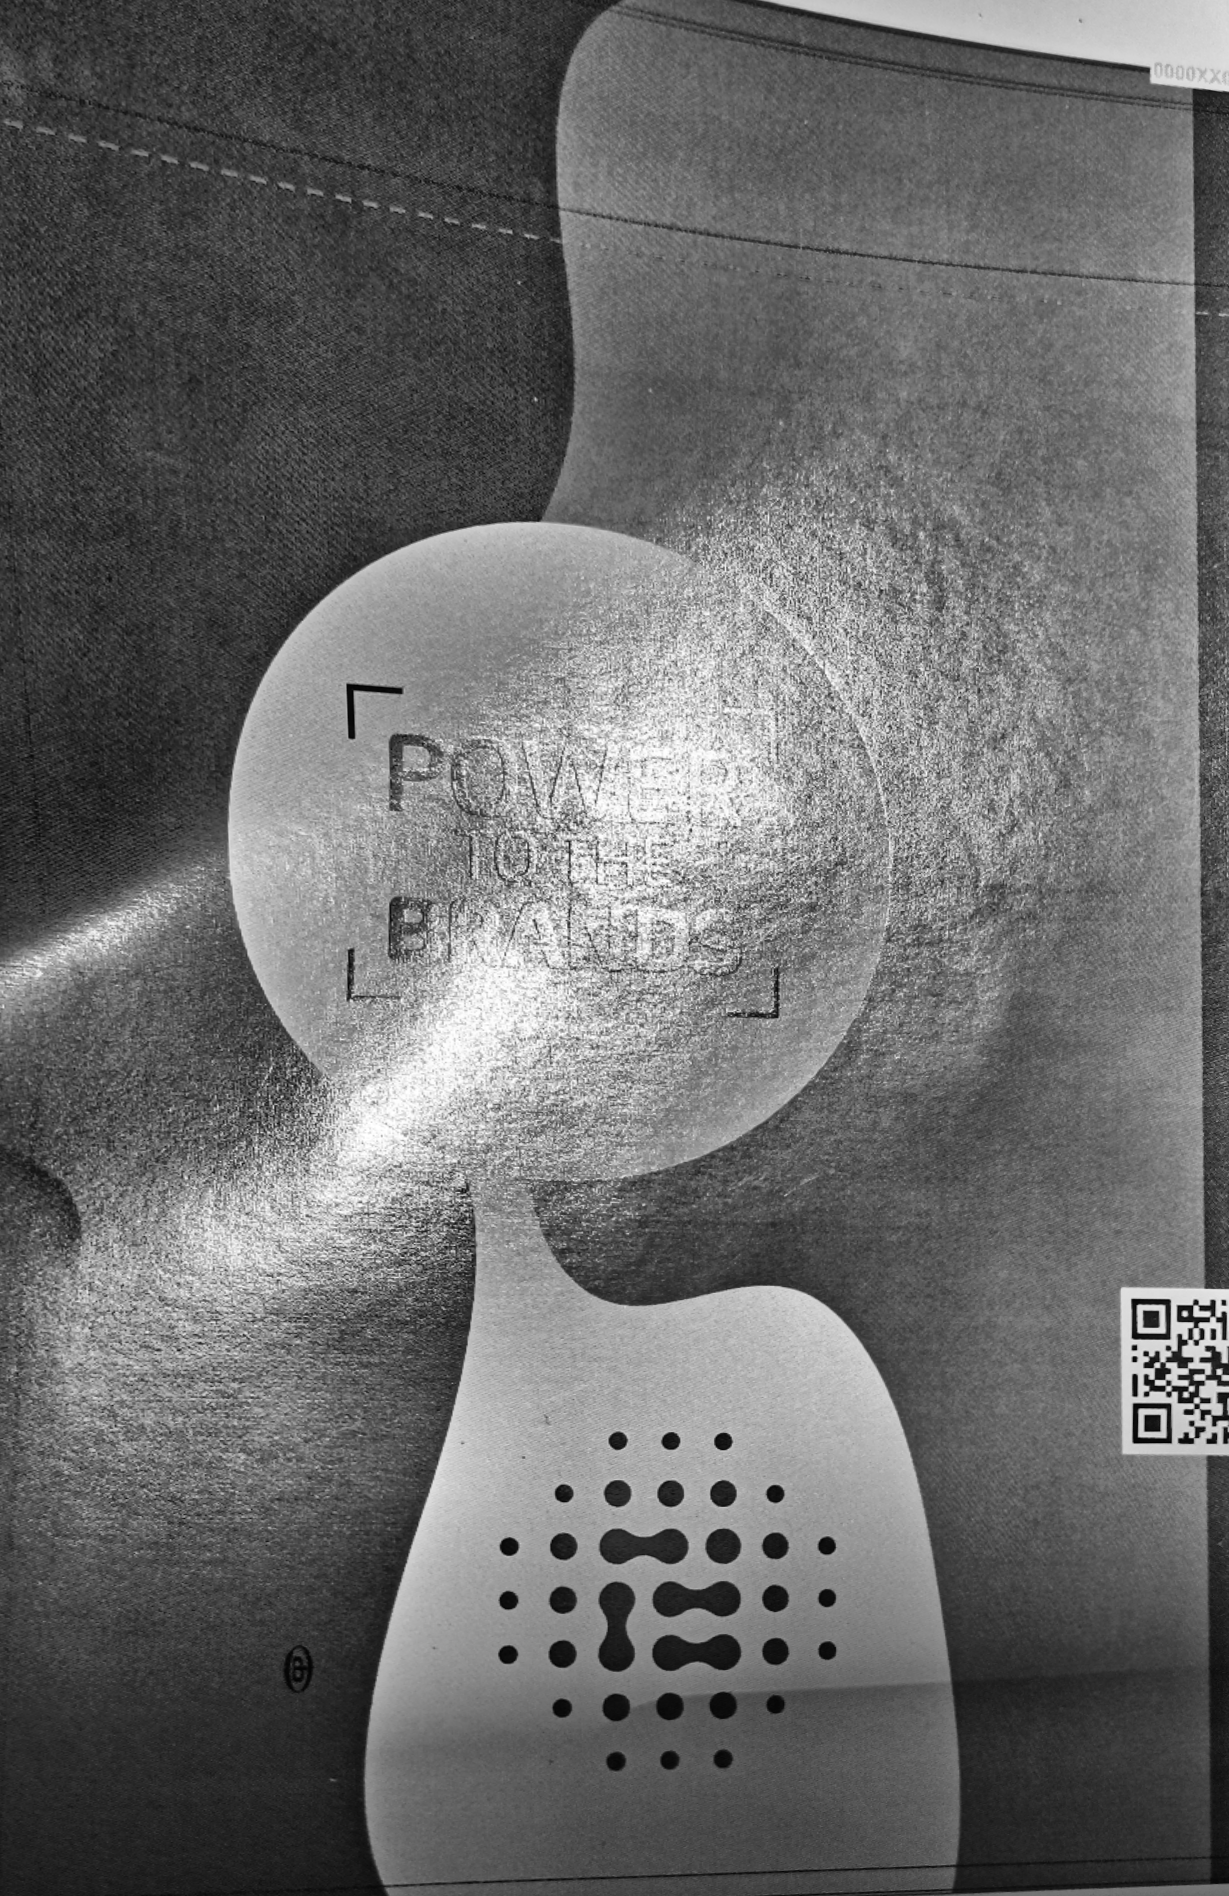

True

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load reference and input images
ref = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/Ennovate Coding Challenge/reference.png', cv2.IMREAD_GRAYSCALE)
inp = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/Ennovate Coding Challenge/input.JPG', cv2.IMREAD_GRAYSCALE)



# Resize input image to the same size as reference image
inp = cv2.resize(inp, ref.shape[::-1])

# Perform exposure and lighting adjustment
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
inp = clahe.apply(inp)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors in reference image and input image
kp1, des1 = sift.detectAndCompute(ref, None)
kp2, des2 = sift.detectAndCompute(inp, None)

# Initialize FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Match keypoints and descriptors in reference image and input image
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Compute homography matrix using RANSAC algorithm
if len(good_matches) > 10:
    ref_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    inp_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(inp_pts, ref_pts, cv2.RANSAC, 5.0)
else:
    H = np.eye(3)

# Apply homography matrix to input image
out = cv2.warpPerspective(inp, H, ref.shape[::-1])

cv2_imshow(out)

# Save the output image
cv2.imwrite(r'/content/drive/MyDrive/Colab Notebooks/Ennovate Coding Challenge/output.jpg', out)

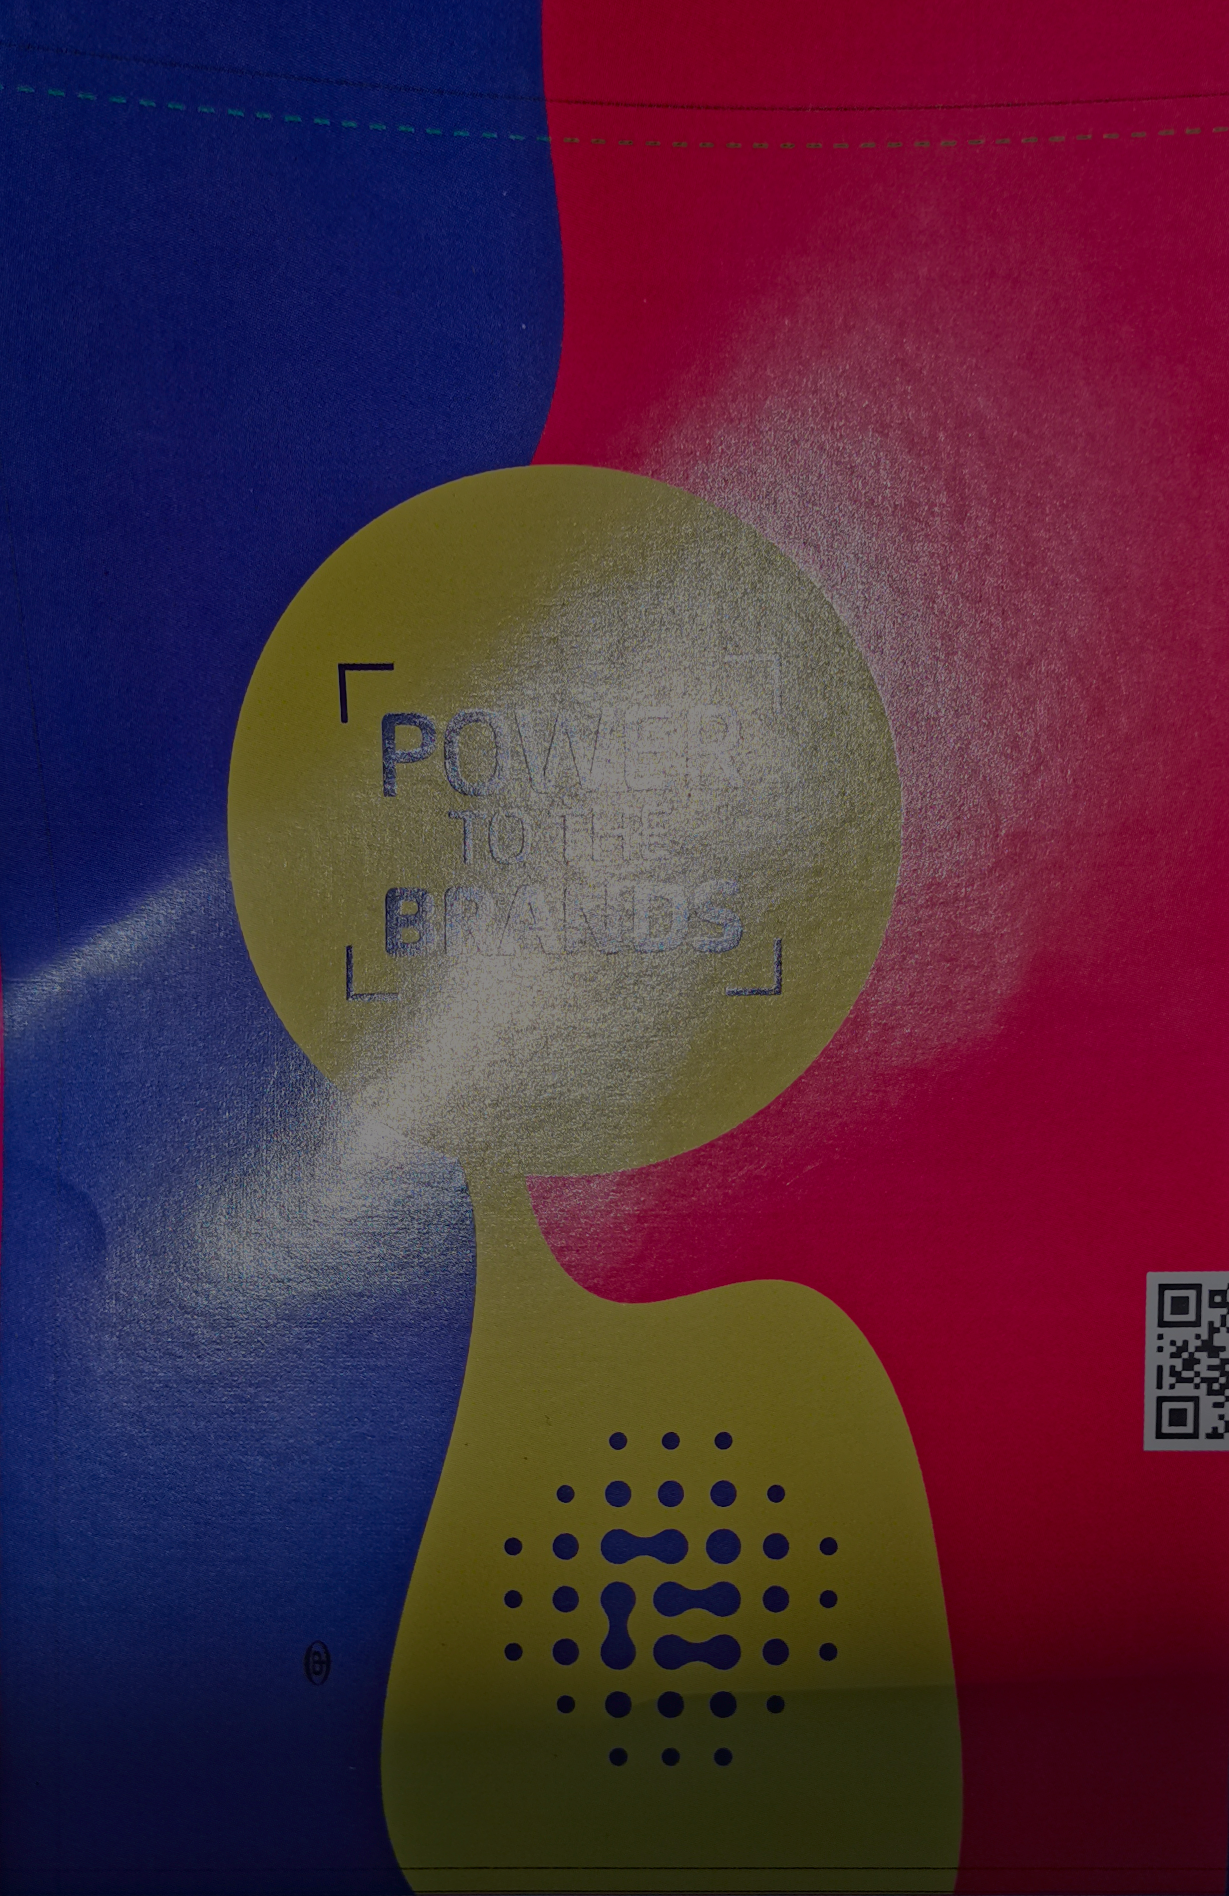

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load the reference and input images
ref_img  = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/Ennovate Coding Challenge/reference.png')
input_img = cv2.imread(r'/content/drive/MyDrive/Colab Notebooks/Ennovate Coding Challenge/input.JPG')


def preprocess_image(input_img, ref_img):
    # Convert input and reference images to LAB color space
    input_lab = cv2.cvtColor(input_img, cv2.COLOR_BGR2LAB)
    ref_lab = cv2.cvtColor(ref_img, cv2.COLOR_BGR2LAB)

    # Scale L channel of input image to match the reference image
    input_l, input_a, input_b = cv2.split(input_lab)
    ref_l, ref_a, ref_b = cv2.split(ref_lab)
    scale = (np.max(ref_l) - np.min(ref_l)) / (np.max(input_l) - np.min(input_l))
    input_l = cv2.convertScaleAbs(input_l, alpha=scale, beta=0)

    # Merge the modified L channel with the original A and B channels
    input_lab = cv2.merge((input_l, input_a, input_b))

    # Convert input image back to BGR color space
    input_img = cv2.cvtColor(input_lab, cv2.COLOR_LAB2BGR)
    input_img = cv2.convertScaleAbs(input_img)

    # Convert input and reference images to grayscale
    input_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)

    # Create SIFT object
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for input and reference images
    kp1, des1 = sift.detectAndCompute(input_gray, None)
    kp2, des2 = sift.detectAndCompute(ref_gray, None)

    # Match keypoints in input and reference images
    matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict())
    matches = matcher.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    # Perform image registration using RANSAC
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    registered_img = cv2.warpPerspective(input_img, M, (ref_img.shape[1], ref_img.shape[0]))

    return registered_img
    

# Preprocess input image to match reference image
result_img = preprocess_image(input_img, ref_img)

# Save result image
cv2_imshow(result_img)